In [1]:
from datetime import datetime 
import pandas_datareader.data as data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import FinanceDataReader as fdr
import time
from pandas.tseries.offsets import BDay

C:\Anaconda\lib\site-packages\pandas_datareader\compat\__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [2]:
# Sector ETF
ticker_name = ['KODEX_반도체', 'KODEX_은행', 'KODEX_자동차', 'KODEX_증권', 'KODEX_철강',
                 'KODEX_건설', 'KODEX_보험', 'KODEX_운송', 'KODEX_바이오', 'KODEX_IT',
                 'KODEX_경기소비재', 'KODEX_필수소비재', 'KODEX_헬스케어', 'KODEX_게임산업',
                 'KODEX_2차전지산업', 'KODEX_미디어&엔터', 'KODEX_기계장비', 'KODEX_에너지화학',
                 'KODEX_200', 'KOSEF_국고채_10년', 'KODEX_골드선물']

ticker_list = ['091160.KS',  '091170.KS', '091180.KS', '102970.KS', '117680.KS', '117700.KS', '140700.KS', 
               '140710.KS', '244580.KS', '266370.KS', '266390.KS', '266410.KS', '266420.KS', '300950.KS', 
               '305720.KS', '266360.KS', '102960.KS', '117460.KS', '069500.KS', '148070.KS', '132030.KS']

ticker_dict = dict(zip(ticker_name,ticker_list))

df = pd.DataFrame()
#전월의 correlation 기준으로 종목을 선정해야하므로
start = datetime(2017,5,1) - BDay(24)
#end = datetime(2020,7,24)
end = datetime.now().date()
df = pd.DataFrame()

In [3]:
#index = pd.bdate_range(start,end,freq='D')
#df = pd.DataFrame(index=index)
for name,ticker in ticker_dict.items():
    print(name,"저장중")
    df[name] = data.DataReader(ticker, 'yahoo', start)['Close']

KODEX_반도체 저장중
KODEX_은행 저장중
KODEX_자동차 저장중
KODEX_증권 저장중
KODEX_철강 저장중
KODEX_건설 저장중
KODEX_보험 저장중
KODEX_운송 저장중
KODEX_바이오 저장중
KODEX_IT 저장중
KODEX_경기소비재 저장중
KODEX_필수소비재 저장중
KODEX_헬스케어 저장중
KODEX_게임산업 저장중
KODEX_2차전지산업 저장중
KODEX_미디어&엔터 저장중
KODEX_기계장비 저장중
KODEX_에너지화학 저장중
KODEX_200 저장중
KOSEF_국고채_10년 저장중
KODEX_골드선물 저장중


In [4]:
# 데이터 전처리
df__2 = df.copy()
df__2.loc['2020-05-06']['KODEX_200'] = 25500

sector_stat = df__2.drop(['KODEX_200', 'KOSEF_국고채_10년', 'KODEX_골드선물'], axis = 1)
sector_stat_2 = sector_stat.shift(1)
sector_stat_3 = sector_stat_2.pct_change()

daily_ret = sector_stat_3.copy()

In [5]:
# low-correlation ETF를 pair 갯수 지정해서 추출하는 함수 (중복 제거되어 sector ETF 수는 지정한 pair 갯수 이하가 됨)
def low_corr_list(date, n_pair): # "2018-03" 
    #전월기준부터 correlation 측정
    date_1M_bf = datetime.strftime(date - BDay(22), '%Y-%m-%d')
    date = datetime.strftime(date - BDay(1), '%Y-%m-%d') 
    dataCorr = daily_ret.loc[date_1M_bf : date].corr(method='pearson')
    dataCorr = dataCorr.stack().reset_index()
    #자기자신과의 correlation 제거
    dataCorr = dataCorr[dataCorr['level_0'].astype(str)!=dataCorr['level_1'].astype(str)]
    #자기자신과 상대방 correlation 중복되는 것 제거
    dataCorr['ordered-cols'] = dataCorr.apply(lambda x: '-'.join(sorted([x['level_0'],x['level_1']])),axis=1)
    dataCorr = dataCorr.drop_duplicates(['ordered-cols'])
    dataCorr.drop(['ordered-cols'], axis=1, inplace=True)
    #내림차순으로 높은 것 n_pair 만큼 추출
    dataCorr = dataCorr.sort_values(by=[0], ascending=True).head(n_pair)
    #set - 순서 없는 형식
    final_list = list(set(dataCorr['level_0'])) + list(set(dataCorr['level_1']) - set(dataCorr['level_0']))    
    return final_list

In [6]:
# low corr df 만들기
# row data를 한달전부터 구해놨기 때문에 다시 한달을 더해서 처음 날짜를 맞춰줘야함
first_date = datetime.strftime(sector_stat_2.index[0] + BDay(24), '%Y-%m-%d')
Date__df = sector_stat_2.drop(sector_stat_2.columns[0:18], axis='columns').loc[first_date:]
date___list=  Date__df.index.tolist()

low_corr_df = daily_ret.copy()
low_corr_df_2 = low_corr_df.loc[first_date:].applymap(lambda x : 0)

for date in date___list  : 
    low_corr_df_2.loc[date, low_corr_list(date, 6)] = 1

In [7]:
low_corr_df_2

,KODEX_반도체,KODEX_은행,KODEX_자동차,KODEX_증권,KODEX_철강,KODEX_건설,KODEX_보험,KODEX_운송,KODEX_바이오,KODEX_IT,KODEX_경기소비재,KODEX_필수소비재,KODEX_헬스케어,KODEX_게임산업,KODEX_2차전지산업,KODEX_미디어&엔터,KODEX_기계장비,KODEX_에너지화학
Date,,,,,,,,,,,,,,,,,,
2017-05-02,0,0,0,0,1,0,0,1,1,1,0,1,1,0,0,1,1,0
2017-05-04,0,0,0,0,1,0,0,0,1,1,0,1,1,0,0,1,1,0
2017-05-08,0,0,1,0,1,0,0,0,1,1,0,1,1,0,0,1,1,0
2017-05-10,0,0,1,0,1,0,0,0,1,1,0,0,1,0,0,1,1,0
2017-05-11,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-03,1,0,0,0,1,0,1,0,0,1,0,0,1,1,0,1,0,0
2020-11-04,1,0,0,0,1,0,1,0,1,1,0,0,1,0,0,1,0,0
2020-11-05,1,0,0,0,1,0,1,0,1,0,0,0,1,1,0,1,0,0


In [8]:
# 1개월 모멘텀 df 만들기

data_mom = sector_stat_2.pct_change(21).loc[first_date:]
data3_mom = data_mom.applymap(lambda x : 1 if x > 0 else 0)
data3_mom_monthly = data3_mom.assign(Date = data3_mom.index).resample('BM').first().set_index('Date')
mom1_1M_rebal = pd.merge(left = Date__df,right = data3_mom_monthly, on = 'Date', how = 'left' ).ffill().fillna(0)

In [9]:
mom1_1M_rebal

,KODEX_반도체,KODEX_은행,KODEX_자동차,KODEX_증권,KODEX_철강,KODEX_건설,KODEX_보험,KODEX_운송,KODEX_바이오,KODEX_IT,KODEX_경기소비재,KODEX_필수소비재,KODEX_헬스케어,KODEX_게임산업,KODEX_2차전지산업,KODEX_미디어&엔터,KODEX_기계장비,KODEX_에너지화학
Date,,,,,,,,,,,,,,,,,,
2017-05-02,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0
2017-05-04,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0
2017-05-08,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0
2017-05-10,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0
2017-05-11,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-03,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
2020-11-04,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
2020-11-05,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0


In [10]:
# low corr과 mom 필터 2개 적용
mom1_corr = mom1_1M_rebal.applymap(lambda x : 0)
mom_df = mom1_1M_rebal.copy()
low_corr_df_3 = low_corr_df_2.copy()

mom1_corr = mom_df.add(low_corr_df_3)
mom1_corr = mom1_corr.applymap(lambda x : 1 if x == 2 else 0)

In [11]:
mom1_corr

,KODEX_반도체,KODEX_은행,KODEX_자동차,KODEX_증권,KODEX_철강,KODEX_건설,KODEX_보험,KODEX_운송,KODEX_바이오,KODEX_IT,KODEX_경기소비재,KODEX_필수소비재,KODEX_헬스케어,KODEX_게임산업,KODEX_2차전지산업,KODEX_미디어&엔터,KODEX_기계장비,KODEX_에너지화학
Date,,,,,,,,,,,,,,,,,,
2017-05-02,0,0,0,0,0,0,0,0,1,1,0,1,1,0,0,1,1,0
2017-05-04,0,0,0,0,0,0,0,0,1,1,0,1,1,0,0,1,1,0
2017-05-08,0,0,0,0,0,0,0,0,1,1,0,1,1,0,0,1,1,0
2017-05-10,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,1,1,0
2017-05-11,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-03,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0
2020-11-04,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0
2020-11-05,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0


In [12]:
# 변동성의 역수 weight 만들기
df_ret = sector_stat_3.copy()

std_1m = df_ret.rolling(21).std().loc[first_date:]

weight_df = std_1m.applymap(lambda x : 1/x)
weight_df2 = weight_df.apply(lambda x : x / x.sum(), axis=1)
weight_df3 = weight_df2.assign(Date = weight_df2.index).resample('BM').first().set_index('Date')
weight_df4 = pd.merge(left = Date__df,right = weight_df3, on = 'Date', how = 'left' ).ffill().fillna(0)

In [23]:
#포트폴리오 수익률 계산을 위한 df
df__5 = df__2.copy()
sector_return = df__5.drop(['KODEX_200', 'KOSEF_국고채_10년', 'KODEX_골드선물'], axis = 1)
sector_return_2 = sector_return.pct_change().loc[first_date:]

In [27]:
sector_return_2

,KODEX_반도체,KODEX_은행,KODEX_자동차,KODEX_증권,KODEX_철강,KODEX_건설,KODEX_보험,KODEX_운송,KODEX_바이오,KODEX_IT,KODEX_경기소비재,KODEX_필수소비재,KODEX_헬스케어,KODEX_게임산업,KODEX_2차전지산업,KODEX_미디어&엔터,KODEX_기계장비,KODEX_에너지화학
Date,,,,,,,,,,,,,,,,,,
2017-05-02,0.010421,0.009404,0.018951,0.024787,0.010875,-0.001709,0.012776,0.000000,-0.006361,-0.002431,0.001895,0.004239,-0.003779,NaN,NaN,0.007715,0.003065,0.005403
2017-05-04,0.013453,0.009317,-0.003720,0.007559,-0.006993,0.000000,0.003440,0.025478,0.011524,0.018031,0.000000,0.029081,-0.000948,NaN,NaN,0.018182,0.002292,-0.003135
2017-05-08,0.012611,0.025231,0.037337,0.015004,0.001625,0.001712,0.011429,0.000000,0.042405,0.010053,0.035934,0.025980,0.045562,NaN,NaN,-0.004229,-0.003049,0.009434
2017-05-10,-0.008958,-0.007803,0.005999,-0.022912,0.005949,0.008547,0.007910,0.000000,-0.009715,0.000000,0.009128,0.020435,0.000908,NaN,NaN,0.001416,0.012997,-0.002670
2017-05-11,0.020723,0.029038,0.016995,0.030257,0.006989,0.016949,-0.003363,0.003106,0.014715,0.018957,0.006332,0.013061,0.015420,NaN,NaN,0.017908,-0.012075,0.019634
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-03,0.023005,0.017422,-0.001588,0.015898,0.016863,0.015351,0.017408,0.006345,0.025969,0.025290,0.012137,0.007638,0.034671,0.005229,0.043058,0.000288,0.017903,0.039326
2020-11-04,0.028354,-0.022260,0.005409,-0.000782,-0.004975,-0.004320,-0.014259,-0.007566,0.026445,0.014000,0.002607,0.008163,0.026385,0.022974,-0.002527,0.040529,-0.006281,-0.006486
2020-11-05,0.015973,0.014886,0.021203,0.014879,0.014167,0.013015,0.001929,0.035578,0.024291,0.024655,0.013521,0.006940,0.022622,0.014407,0.041807,0.014917,0.020228,0.040624


In [24]:
# 포트폴리오 df 만들기
daily_portfolio_ret = sector_return_2.copy()
daily_portfolio_ret2 = daily_portfolio_ret.drop(daily_portfolio_ret.columns[0:18], axis=1)
daily_portfolio_ret2['1_Mom_Corr_Rebal_1M'] = float(0)
daily_portfolio_ret4 = daily_portfolio_ret2.copy()

In [25]:
daily_portfolio_ret4

,1_Mom_Corr_Rebal_1M
Date,
2017-05-02,0.0
2017-05-04,0.0
2017-05-08,0.0
2017-05-10,0.0
2017-05-11,0.0
...,...
2020-11-03,0.0
2020-11-04,0.0
2020-11-05,0.0


In [28]:
weight_df4

,KODEX_반도체,KODEX_은행,KODEX_자동차,KODEX_증권,KODEX_철강,KODEX_건설,KODEX_보험,KODEX_운송,KODEX_바이오,KODEX_IT,KODEX_경기소비재,KODEX_필수소비재,KODEX_헬스케어,KODEX_게임산업,KODEX_2차전지산업,KODEX_미디어&엔터,KODEX_기계장비,KODEX_에너지화학
Date,,,,,,,,,,,,,,,,,,
2017-05-02,0.066295,0.047199,0.051153,0.047250,0.065595,0.065401,0.066216,0.057907,0.052809,0.085123,0.060356,0.060412,0.084825,0.000000,0.000000,0.055026,0.064967,0.069468
2017-05-04,0.066295,0.047199,0.051153,0.047250,0.065595,0.065401,0.066216,0.057907,0.052809,0.085123,0.060356,0.060412,0.084825,0.000000,0.000000,0.055026,0.064967,0.069468
2017-05-08,0.066295,0.047199,0.051153,0.047250,0.065595,0.065401,0.066216,0.057907,0.052809,0.085123,0.060356,0.060412,0.084825,0.000000,0.000000,0.055026,0.064967,0.069468
2017-05-10,0.066295,0.047199,0.051153,0.047250,0.065595,0.065401,0.066216,0.057907,0.052809,0.085123,0.060356,0.060412,0.084825,0.000000,0.000000,0.055026,0.064967,0.069468
2017-05-11,0.066295,0.047199,0.051153,0.047250,0.065595,0.065401,0.066216,0.057907,0.052809,0.085123,0.060356,0.060412,0.084825,0.000000,0.000000,0.055026,0.064967,0.069468
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-03,0.053267,0.050008,0.042029,0.051345,0.051820,0.075864,0.054059,0.051714,0.039878,0.089849,0.059364,0.074976,0.046464,0.050822,0.054406,0.051780,0.057110,0.045245
2020-11-04,0.053267,0.050008,0.042029,0.051345,0.051820,0.075864,0.054059,0.051714,0.039878,0.089849,0.059364,0.074976,0.046464,0.050822,0.054406,0.051780,0.057110,0.045245
2020-11-05,0.053267,0.050008,0.042029,0.051345,0.051820,0.075864,0.054059,0.051714,0.039878,0.089849,0.059364,0.074976,0.046464,0.050822,0.054406,0.051780,0.057110,0.045245


In [26]:
mom1_corr

,KODEX_반도체,KODEX_은행,KODEX_자동차,KODEX_증권,KODEX_철강,KODEX_건설,KODEX_보험,KODEX_운송,KODEX_바이오,KODEX_IT,KODEX_경기소비재,KODEX_필수소비재,KODEX_헬스케어,KODEX_게임산업,KODEX_2차전지산업,KODEX_미디어&엔터,KODEX_기계장비,KODEX_에너지화학
Date,,,,,,,,,,,,,,,,,,
2017-05-02,0,0,0,0,0,0,0,0,1,1,0,1,1,0,0,1,1,0
2017-05-04,0,0,0,0,0,0,0,0,1,1,0,1,1,0,0,1,1,0
2017-05-08,0,0,0,0,0,0,0,0,1,1,0,1,1,0,0,1,1,0
2017-05-10,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,1,1,0
2017-05-11,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-03,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0
2020-11-04,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0
2020-11-05,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0


In [29]:
sector_return_2

,KODEX_반도체,KODEX_은행,KODEX_자동차,KODEX_증권,KODEX_철강,KODEX_건설,KODEX_보험,KODEX_운송,KODEX_바이오,KODEX_IT,KODEX_경기소비재,KODEX_필수소비재,KODEX_헬스케어,KODEX_게임산업,KODEX_2차전지산업,KODEX_미디어&엔터,KODEX_기계장비,KODEX_에너지화학
Date,,,,,,,,,,,,,,,,,,
2017-05-02,0.010421,0.009404,0.018951,0.024787,0.010875,-0.001709,0.012776,0.000000,-0.006361,-0.002431,0.001895,0.004239,-0.003779,NaN,NaN,0.007715,0.003065,0.005403
2017-05-04,0.013453,0.009317,-0.003720,0.007559,-0.006993,0.000000,0.003440,0.025478,0.011524,0.018031,0.000000,0.029081,-0.000948,NaN,NaN,0.018182,0.002292,-0.003135
2017-05-08,0.012611,0.025231,0.037337,0.015004,0.001625,0.001712,0.011429,0.000000,0.042405,0.010053,0.035934,0.025980,0.045562,NaN,NaN,-0.004229,-0.003049,0.009434
2017-05-10,-0.008958,-0.007803,0.005999,-0.022912,0.005949,0.008547,0.007910,0.000000,-0.009715,0.000000,0.009128,0.020435,0.000908,NaN,NaN,0.001416,0.012997,-0.002670
2017-05-11,0.020723,0.029038,0.016995,0.030257,0.006989,0.016949,-0.003363,0.003106,0.014715,0.018957,0.006332,0.013061,0.015420,NaN,NaN,0.017908,-0.012075,0.019634
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-03,0.023005,0.017422,-0.001588,0.015898,0.016863,0.015351,0.017408,0.006345,0.025969,0.025290,0.012137,0.007638,0.034671,0.005229,0.043058,0.000288,0.017903,0.039326
2020-11-04,0.028354,-0.022260,0.005409,-0.000782,-0.004975,-0.004320,-0.014259,-0.007566,0.026445,0.014000,0.002607,0.008163,0.026385,0.022974,-0.002527,0.040529,-0.006281,-0.006486
2020-11-05,0.015973,0.014886,0.021203,0.014879,0.014167,0.013015,0.001929,0.035578,0.024291,0.024655,0.013521,0.006940,0.022622,0.014407,0.041807,0.014917,0.020228,0.040624


In [30]:
# 골드선물 수익률
KODEX_골드선물 = pd.DataFrame(df__2['KODEX_골드선물']).pct_change().loc[first_date:]

# 포트폴리오 ETF 갯수 0일때 골드선물etf 매입 로직 추가
# 백테스팅 날짜 : date___list / low corr & momentum filter : mom1_corr 
# 수익률 : sector_return_2 / 종목비중 : weight_df5

for i in date___list :
    if mom1_corr.loc[i].sum() == 0  :
        daily_portfolio_ret4.loc[i] = KODEX_골드선물.loc[i][0]
        pass
        
    for j in range(0,18) :      
        if mom1_corr.loc[i][j] == 1 :
            daily_portfolio_ret4.loc[i] += sector_return_2.loc[i][j] * weight_df4.loc[i][j]

In [31]:
# 벤치마크와 비교 'KODEX_200', 'KOSEF_국고채_10년'
benchmark_df = pd.concat([df__5['KODEX_200'], df__5['KOSEF_국고채_10년']],axis = 1)
benchmark_df.loc['2020-05-06']['KODEX_200'] = 25500
benchmark_df2 = benchmark_df.pct_change().loc[first_date:]

In [32]:
benchmark_df2

,KODEX_200,KOSEF_국고채_10년
Date,,
2017-05-02,0.007827,-0.002688
2017-05-04,0.010010,0.000171
2017-05-08,0.026145,-0.001968
2017-05-10,-0.010824,-0.001372
2017-05-11,0.012458,-0.004335
...,...,...
2020-11-03,0.019935,-0.000080
2020-11-04,0.006248,0.002943
2020-11-05,0.021971,0.003251


In [34]:
final_df3

,1_Mom_Corr_Rebal_1M,KODEX_200,KOSEF_국고채_10년
Date,,,
2017-05-02,1.634291e-05,0.007827,-0.002688
2017-05-04,4.969154e-03,0.010010,0.000171
2017-05-08,8.098596e-03,0.026145,-0.001968
2017-05-10,4.862608e-04,-0.010824,-0.001372
2017-05-11,3.899623e-03,0.012458,-0.004335
...,...,...,...
2020-11-03,1.814921e-03,0.019935,-0.000080
2020-11-04,-1.028611e-03,0.006248,0.002943
2020-11-05,8.383734e-04,0.021971,0.003251


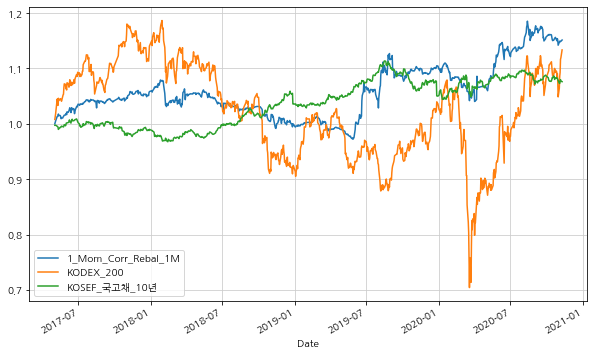

In [35]:
#세금미적용의 경우
final_df3 = pd.concat([daily_portfolio_ret4, benchmark_df2['KODEX_200'],
                      benchmark_df2['KOSEF_국고채_10년']],axis=1)
#벤치마크와 비교
matplotlib.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['axes.edgecolor'] = 'black'
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 1
plt.rcParams['grid.color'] = "#cccccc"
final_df3.add(1).cumprod().plot(figsize=(10,6))

In [36]:
# (세금계산전) Sector ETF 전략 포트폴리오 연 수익률
print('sector_etf : ' +  str( ( (final_df3['1_Mom_Corr_Rebal_1M'].add(1).cumprod()[-1] - 1) / len(final_df3) ) * 252 )[:7])
# (세금계산전) KODEX 200 연 수익률
print('kodex_200 : ' +  str( ( (final_df3['KODEX_200'].add(1).cumprod()[-1] - 1) / len(final_df3) ) * 252 )[:7])
# (세금계산전) 국고채10년 연 수익률
print('bond_10_year : ' +  str( ( (final_df3['KOSEF_국고채_10년'].add(1).cumprod()[-1] - 1) / len(final_df3) ) * 252 )[:7])

sector_etf : 0.04480
kodex_200 : 0.03950
bond_10_year : 0.02252


In [39]:
# (세금계산전) KODEX 200 연 수익률 
print( ( (final_df3['KODEX_200'].add(1).cumprod()[-1] - 1) / len(final_df3) ) * 252 )

0.03950699850932173


In [40]:
# (세금계산전) 국고채10년 연 수익률 
( (final_df3['KOSEF_국고채_10년'].add(1).cumprod()[-1] - 1) / len(final_df3) ) * 252

0.022527878949628318

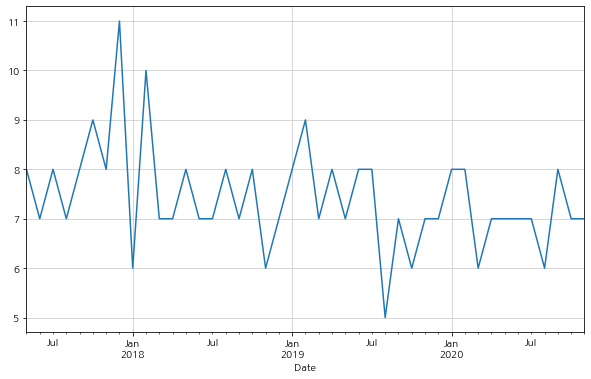

In [41]:
# low_corr 필터 걸러진 sector ETF 갯수 확인
low_corr_ETF = low_corr_df_2.resample('BM').first()
low_corr_ETF['low_corr'] = low_corr_ETF.sum(axis=1)
low_corr_ETF['low_corr'].plot(figsize=(10,6))

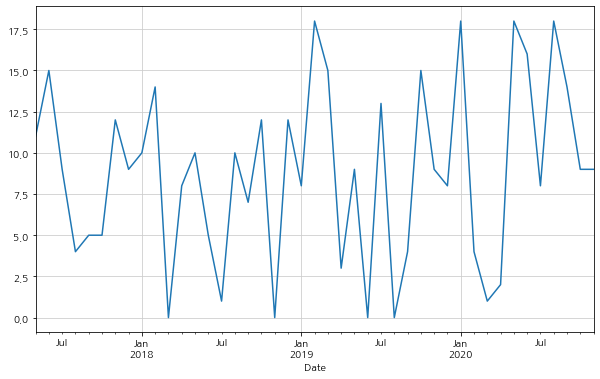

In [42]:
# momentum 필터 걸러진 sector ETF 갯수 확인
mom_ETF = data3_mom.resample('BM').first()
mom_ETF['mom'] = mom_ETF.sum(axis=1)
mom_ETF['mom'].plot(figsize=(10,6))

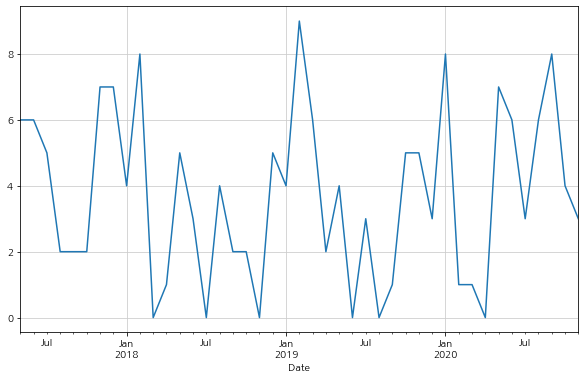

In [43]:
# low_corr / momentum 필터 걸러진 sector ETF 갯수 확인
low_corr_mom_ETF = mom1_corr.resample('BM').first()
low_corr_mom_ETF['low_corr_mom'] = low_corr_mom_ETF.sum(axis=1)
low_corr_mom_ETF['low_corr_mom'].plot(figsize=(10,6))

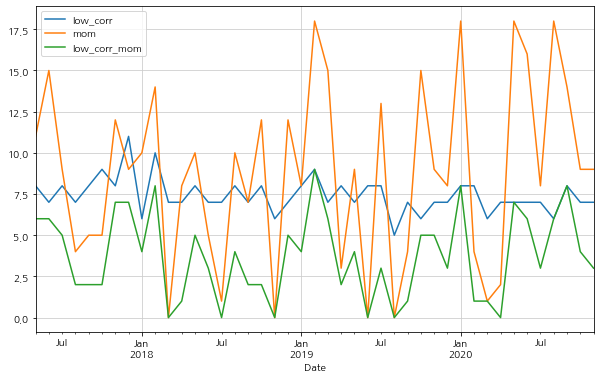

In [44]:
# 비교 해보기
low_corr_ETF_df = pd.DataFrame(low_corr_ETF['low_corr'])
mom_ETF_df = pd.DataFrame(mom_ETF['mom'])
low_corr_mom_ETF_df = pd.DataFrame(low_corr_mom_ETF['low_corr_mom'])

compare___df = pd.concat([low_corr_ETF_df, mom_ETF_df, low_corr_mom_ETF_df], axis =1 )
compare___df.plot(figsize = (10,6))

In [45]:
# low_corr / momentum 필터 걸러진 sector ETF 갯수 평균
low_corr_mom_ETF['low_corr_mom'].mean()

3.7209302325581395